In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount=True)

os.chdir('gdrive/My Drive/Data_science_eng/finalproject/image-captioning-gru')
print("Current working directory: {0}".format(os.getcwd()))

Mounted at /content/gdrive
Current working directory: /content/gdrive/My Drive/Data_science_eng/finalproject/image-captioning-gru


In [2]:
import pandas as pd
import pickle
import numpy as np
from keras.preprocessing import image, sequence
import tensorflow as tf

In [3]:
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

tf.test.is_built_with_cuda()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



True

In [4]:
images_dir = os.listdir("../data/Flickr_Data/Flickr_Data")

images_path = '../data/Flickr_Data/Flickr_Data/Images/'
captions_path = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '../data/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [5]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

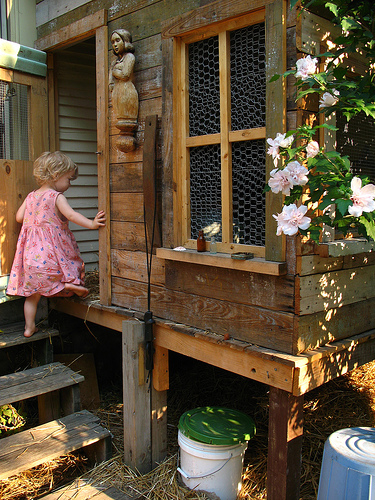

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [6]:
# displaying an image and captions given to it
temp = captions[0].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [7]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [8]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        # caption = capt
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        # caption = capt
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        # caption = capt
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [9]:
train_data = pd.read_csv('flickr_8k_train_dataset.txt', delimiter='\t')
val_data = pd.read_csv('flickr_8k_val_dataset.txt', delimiter='\t')
train_sents_data = train_data.values
val_sents_data = val_data.values

In [10]:
train_sents = []
val_sents = []
for ix in range(train_sents_data.shape[0]):
  train_sents.append(train_sents_data[ix,1])

for ix in range(val_sents_data.shape[0]):
  val_sents.append(val_sents_data[ix,1])


In [11]:
print(len(train_sents))
print(len(val_sents))

30000
5000


In [12]:
words = [i.split() for i in train_sents]
# words = [i.split() for i in val_sents]
words.extend([i.split() for i in val_sents])

In [13]:
unique = []
for ix in range(len(words)):
  unique.extend(words[ix])

unique = list(set(unique))

print(len(unique))

8918


In [14]:
words_to_indices = {word:idx for idx,word in enumerate(unique)}
indices_to_words = {idx:word for idx,word in enumerate(unique)}

total_words = len(unique)
word_0idx = indices_to_words[0]
indices_to_words[0] = 'UNK'
words_to_indices['UNK'] = 0
words_to_indices[word_0idx] = total_words
indices_to_words[total_words] = word_0idx
print(total_words, len(words_to_indices.keys()))

8918 8919


In [15]:
print(type(words_to_indices))

print(words_to_indices['<start>'])
print(len(words_to_indices))
print(words_to_indices)

<class 'dict'>
4847
8919
{'great': 8918, 'tractor': 1, 'endzone': 2, 'weating': 3, 'reclines': 4, 'tomatos': 5, 'pedigree': 6, 'competitive': 7, 'theme': 8, 'Teenager': 9, 'atmosphere': 10, 'poorly': 11, 'snowsuit': 12, 'rockets': 13, 'someplace': 14, 'mouthing': 15, 'is': 16, 'stuff': 17, ':': 18, 'sailboat': 19, 'boogie-board': 20, 'headbands': 21, 'stuffed': 22, 'piggy': 23, 'gushing': 24, 'Ghostbusters': 25, 'New': 26, '25': 27, 'counters': 28, 'magenta': 29, 'paint': 30, 'farward': 31, 'ski-ing': 32, 'striking': 33, 'whites': 34, 'fenced': 35, 'Motorcycle': 36, 'flash': 37, 'Average': 38, 'confetti': 39, 'rushes': 40, 'skateboarding': 41, 'depicts': 42, 'hurrying': 43, 'upset': 44, 'Orange': 45, 'Ghandi': 46, 'surges': 47, 'foreign': 48, 'decked': 49, 'sorts': 50, 'steap': 51, 'down': 52, 'restroom': 53, 'mucky': 54, 'lighted': 55, 'thumbs': 56, 'assistance': 57, 'lambs': 58, 'Applebee': 59, 'skewed': 60, 'adobe': 61, 'witches': 62, 'investigating': 63, 'own': 64, 'backround': 65,

In [16]:
with open('words_to_indices.pickle', 'wb') as handle:
    pickle.dump(words_to_indices, handle)
with open('indices_to_words.pickle', 'wb') as handle:
    pickle.dump(indices_to_words, handle)

In [17]:
maxLen = 0
for ix in range(len(words)):
  maxLen = max(maxLen, len(words[ix]))

print(maxLen)

40


In [18]:
padded_seqs, subsequent_seqs = [] ,[]

for ix in range(train_sents_data.shape[0]): 
  text = train_sents_data[ix,1].split()
  text = [words_to_indices[i] for i in text]
  train_next_words = text[1:]
  seq = text[:-1]
  padded_seqs.append(seq)
  subsequent_seqs.append(train_next_words)
train_captions = sequence.pad_sequences(padded_seqs, maxLen, padding='post')
train_next_words = sequence.pad_sequences(subsequent_seqs, maxLen, padding='post')
train_next_words = train_next_words.reshape((train_next_words.shape[0],train_next_words.shape[1],1))

In [19]:
padded_seqs, subsequent_seqs = [] ,[]

for ix in range(val_sents_data.shape[0]):  
  text = val_sents_data[ix,1].split()
  text = [words_to_indices[i] for i in text]
  val_next_words = text[1:]
  seq = text[:-1]
  padded_seqs.append(seq)
  subsequent_seqs.append(val_next_words)
val_captions = sequence.pad_sequences(padded_seqs, maxLen, padding='post')
val_next_words = sequence.pad_sequences(subsequent_seqs, maxLen, padding='post')
val_next_words = val_next_words.reshape((val_next_words.shape[0],val_next_words.shape[1],1))

In [20]:
print(train_captions.shape, train_next_words.shape)
print(val_captions.shape, val_next_words.shape)

(30000, 40) (30000, 40, 1)
(5000, 40) (5000, 40, 1)


In [21]:
with open('./train_embs.pickle', 'rb') as file:
  encoded_train_images = pickle.load(file)
with open('./val_embs.pickle', 'rb') as file:
  encoded_val_images = pickle.load(file)

In [22]:
train_imgs = []
for ix in range(train_sents_data.shape[0]):
  train_img = encoded_train_images[train_sents_data[ix,0]]
  train_img = train_img.reshape((2048,))
  train_imgs.append(train_img)

val_imgs = []
for ix in range(val_sents_data.shape[0]):
  val_img = encoded_val_images[val_sents_data[ix,0]]
  val_img = val_img.reshape((2048,))
  val_imgs.append(val_img)

In [23]:
train_imgs = np.array(train_imgs)
print(train_imgs.shape)
val_imgs = np.array(val_imgs)
print(val_imgs.shape)

(30000, 2048)
(5000, 2048)


In [24]:
np.save("./captions_train.npy", train_captions)
np.save("./next_words_train.npy", train_next_words)
np.save("./images_train.npy", train_imgs)

np.save("./captions_val.npy", val_captions)
np.save("./next_words_val.npy", val_next_words)
np.save("./images_val.npy", val_imgs)

In [25]:
print( words_to_indices['<start>'])

4847
